# K-Means Clustering
Cluster splats using K-Means clustering.
This is the offline "oracle" version of the clustering.

In [1]:
# Path to the CSV file containing the collected splats.
DATA_NAME = "collected_splats"

# Number of clusters.
CLUSTERS = 12

In [2]:
import numpy as np

from clustering_exploration.utils.data_handler import load_splats

In [3]:
splats = load_splats(DATA_NAME)

# Cluster Splats
For each pixel,
1. Run k-means clustering on all splats.
2. Within each cluster, commutatively sum the alpha and color values.

In [4]:
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import os
from sklearn.cluster import KMeans

In [5]:
# Restrict the number of threads to 1 for kmeans.
os.environ['OMP_NUM_THREADS'] = '1'

In [6]:
def cluster_pixel(pixel_splats, clusters):
    """Compute clustering on a single pixel."""

    # Get depth values.
    depths = pixel_splats[:, 1]

    # Run K-Means clustering.
    kmeans = KMeans(n_clusters=clusters).fit(depths.reshape(-1, 1))

    # Initialize clustering 2D list: cluster -> [[alpha, depth, *color], ...].
    pixel_clustering = [[] for _ in range(clusters)]

    # Loop through each splat and place it in the appropriate cluster.
    for splat_index, cluster_index in enumerate(kmeans.labels_):
        pixel_clustering[cluster_index].append(pixel_splats[splat_index])

    # Commutatively combine cluster values [[median depth, alpha, color], ...].
    depth_clusters = np.empty((clusters, 5))
    for cluster_index, cluster_splats in enumerate(pixel_clustering):
        # Convert to numpy array.
        cluster_splats_array = np.array(cluster_splats)

        # Compute fields.
        depth_clusters[cluster_index, 0] = np.median(cluster_splats_array[:, 1])
        depth_clusters[cluster_index, 1] = 1 - np.prod(1 - cluster_splats_array[:, 0])
        alpha_sum = np.sum(cluster_splats_array[:, 0])
        if alpha_sum:
            depth_clusters[cluster_index, 2:] = np.sum(
                cluster_splats_array[:, 0].reshape(-1, 1) * cluster_splats_array[:, 2:],
                axis=0) / alpha_sum
        else:
            depth_clusters[cluster_index, 2:] = np.zeros(3)

    return depth_clusters[np.argsort(depth_clusters[:, 0])]


## Do the Clustering
1. Shuffle the splats in each pixel.
2. Cluster the splats.

In [7]:
# Shuffle the splats in each pixel.
rng = np.random.default_rng()
rng.shuffle(splats, axis=1)

In [8]:
# Cluster shuffled splats.
clustered_splats = Parallel(n_jobs=-1)(delayed(cluster_pixel)(pixel_splats, CLUSTERS) for pixel_splats in tqdm(splats))

  0%|          | 0/1051648 [00:00<?, ?it/s]

# Compute Image From Clusters
Compute the final pixel color by alpha compositing the clusters.

In [9]:
from clustering_exploration.utils.image_handler import compute_image_from_clusters

  0%|          | 0/1051648 [00:00<?, ?it/s]

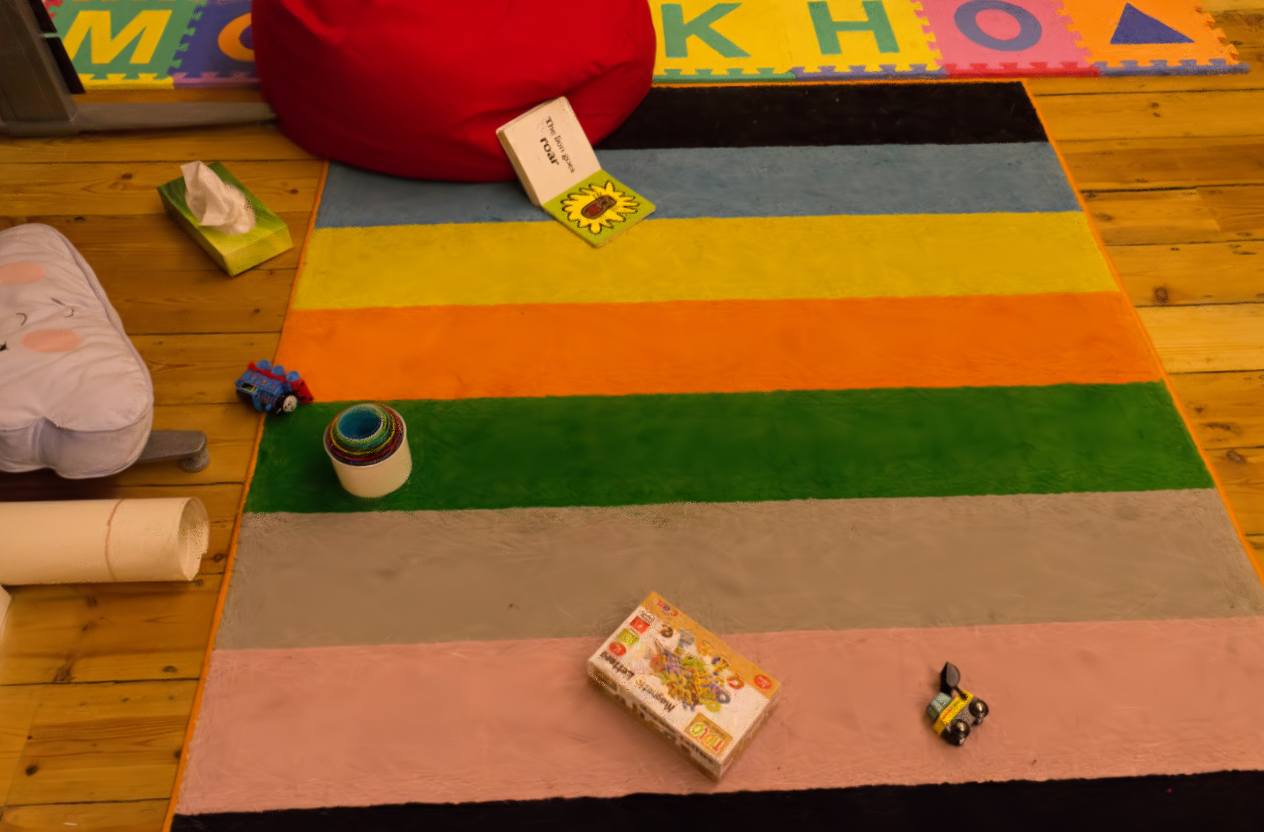

In [10]:
display(compute_image_from_clusters(np.array(clustered_splats)[:, :, 1:], f"k_means_clustering_k_{CLUSTERS}"))